## 1. Setup & Imports

In [1]:
# Core
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Hugging Face
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Ensure results folder exists
os.makedirs("../data/processed/tokenized", exist_ok=True)

## 2. Load Cleaned Dataset

In [2]:
df = pd.read_csv("../data/processed/cleaned_for_preprocessing.csv")
print(df.shape)
df.head()

(44898, 9)


,title,text,subject,date,label,label_name,text_len,title_len,clean_text
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1,Fake,361,11,donald trump white house chaos trying cover ru...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1,Fake,495,9,donald trump presumptive gop nominee time reme...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1,Fake,379,14,mike pence huge homophobe supports exgay conve...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0,Real,88,9,san francisco reuters california attorney gene...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1,Fake,138,19,twisted reasoning comes pelosi days especially...


## 3. Minimal Text Cleaning

In [3]:
import re
import html

def clean_minimal(text):
    text = html.unescape(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["combined_text"] = (df["title"].fillna("") + " " + df["text"].fillna("")).apply(clean_minimal)
df = df[["combined_text", "label"]]
df.head()

,combined_text,label
0,BREAKING: GOP Chairman Grassley Has Had Enough...,1
1,Failed GOP Candidates Remembered In Hilarious ...,1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY ...,1
3,California AG pledges to defend birth control ...,0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,1


## 4. Stratified Train/Validation/Test Split

In [4]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

for name, d in zip(["Train", "Validation", "Test"], [train_df, val_df, test_df]):
    print(f"{name}: {len(d)} samples | Fake: {d['label'].sum()} | Real: {(1 - d['label']).sum()}")

train_df.to_csv("../data/processed/train.csv", index=False)
val_df.to_csv("../data/processed/val.csv", index=False)
test_df.to_csv("../data/processed/test.csv", index=False)

Train: 35918 samples | Fake: 18785 | Real: 17133
Validation: 4490 samples | Fake: 2348 | Real: 2142
Test: 4490 samples | Fake: 2348 | Real: 2142


## 5. Load Tokenizer (DistilBERT)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
MAX_LEN = 256

## 6. Convert DataFrames → HF Datasets

In [6]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

dataset

DatasetDict({
    train: Dataset({
        features: ['combined_text', 'label', '__index_level_0__'],
        num_rows: 35918
    })
    validation: Dataset({
        features: ['combined_text', 'label', '__index_level_0__'],
        num_rows: 4490
    })
    test: Dataset({
        features: ['combined_text', 'label', '__index_level_0__'],
        num_rows: 4490
    })
})

## 7. Tokenization Function

In [7]:
def tokenize_function(batch):
    return tokenizer(
        batch["combined_text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")

tokenized_datasets

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 35918
    })
    validation: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4490
    })
    test: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4490
    })
})

## 8. Token Length Distribution (for visualization)

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


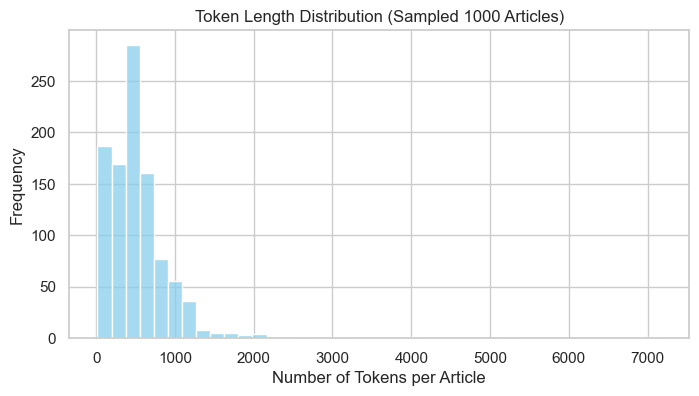

Mean length: 526.6, 95th percentile: 1156.2499999999998


In [8]:
lengths = [
    len(tokenizer(text)["input_ids"]) 
    for text in df.sample(1000, random_state=42)["combined_text"]
]

plt.figure(figsize=(8,4))
sns.histplot(lengths, bins=40, color="skyblue")
plt.title("Token Length Distribution (Sampled 1000 Articles)")
plt.xlabel("Number of Tokens per Article")
plt.ylabel("Frequency")
plt.savefig("../results/eda/token_length_distribution.png", bbox_inches="tight")
plt.show()

print(f"Mean length: {np.mean(lengths):.1f}, 95th percentile: {np.percentile(lengths, 95)}")

## 9. Sample Decoding Check

In [9]:
sample = tokenized_datasets["train"][0]
print("Encoded sample keys:", sample.keys())
print("Decoded text:\n", tokenizer.decode(sample["input_ids"][:80]))
print("Label:", sample["label"])

Encoded sample keys: dict_keys(['label', '__index_level_0__', 'input_ids', 'attention_mask'])
Decoded text:
 [CLS] epa inspector general to investigate agency chief ' s travels to oklahoma washington / new york ( reuters ) - the frequent travels of the head of the u. s. environmental protection agency, scott pruitt, to oklahoma will be investigated following congressional requests, the agency ’ s office of inspector general said on monday. pruitt ’ s many travels to his home state have fueled speculation that he intends
Label: tensor(0)


## 10. Save Tokenized Dataset for Training

In [10]:
tokenized_datasets.save_to_disk("../data/processed/tokenized")
print("✅ Tokenized datasets saved to data/processed/tokenized/")

Saving the dataset (0/1 shards):   0%|          | 0/35918 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4490 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4490 [00:00<?, ? examples/s]

✅ Tokenized datasets saved to data/processed/tokenized/


## 11. Preprocessing Summary

1. Loaded cleaned dataset from Commit 1
2. Performed minimal text cleaning (HTML, URLs, spacing)
3. Combined title + body into single column
4. Stratified train/val/test split (80/10/10)
5. Tokenized using DistilBERT (max length 256)
6. Saved tokenized dataset for fine-tuning